In [1]:
import pandas as pd

from time import perf_counter
from numpy import mean

from mlxtend.frequent_patterns import fpgrowth, apriori
from mlxtend.preprocessing import TransactionEncoder

from eclat_algo import eclat

import os.path as osp

In [2]:
data = pd.read_csv(osp.join('..', 'Data', 'processed.csv'))

transformed_df = data.copy(deep=True)
transformed_df['Tid'] = transformed_df['Member_number'].astype('str') + '-' +\
                        transformed_df['Date'].astype('str') + '-' +\
                        transformed_df['Month'].astype('str') + '-' +\
                        transformed_df['Year'].astype('str')
transformed_df.drop(['Member_number', 'Date', 'Month', 'Year'], axis=1, inplace=True)
transformed_df

,itemDescription,Tid
0,tropical fruit,1808-21-7-2015
1,whole milk,2552-5-1-2015
2,pip fruit,2300-19-9-2015
3,other vegetables,1187-12-12-2015
4,whole milk,3037-1-2-2015
...,...,...
38001,sliced cheese,4471-8-10-2014
38002,candy,2022-23-2-2014
38003,cake bar,1097-16-4-2014
38004,fruit/vegetable juice,1510-3-12-2014


In [3]:
transactions = transformed_df.groupby('Tid')\
                             .aggregate(list)

encoder = TransactionEncoder()
encoder.fit(transactions['itemDescription'].values)
array = encoder.transform(transactions['itemDescription'].values)
ml_df = pd.DataFrame(array, columns=encoder.columns_)

In [ ]:
no_run = 100
minSups = [i / 1000 for i in range(5, 10)].extend(i / 100 for i in range(5, 10)[])
times = {'apriori': [],
         'fp_growth': [],
         'eclat': []}

for minSup in minSups:
    results = {'apri': [],
               'fp': [],
               'eclat': []}
    for _ in range(no_run):
        start = perf_counter()
        apriori(ml_df, minSup, use_colnames = True)
        end = perf_counter()
        results['apri'].append(end - start)

        start = perf_counter()
        fpgrowth(ml_df, minSup, use_colnames = True)
        end = perf_counter()
        results['fp'].append(end - start)
        
        start = perf_counter()
        eclat(transformed_df, minSup, 'itemDescription')
        end = perf_counter()
        results['eclat'].append(end - start)
    
    times['apriori'].append(mean(results['apri']))
    times['fp_growth'].append(mean(results['fp']))
    times['eclat'].append(mean(results['eclat']))

In [5]:
df = pd.concat([pd.DataFrame(times),
                pd.DataFrame(minSups, columns=['minSup'])], axis=1)
df = df.set_index('minSup')
df.columns = ['Apriorpri (mlxtend)', 'FP-Growth (mlxtend)', 'ECLAT']
df.to_csv(osp.join('..', 'Output', 'timing.csv'))

In [7]:
import matplotlib.pyplot as plt

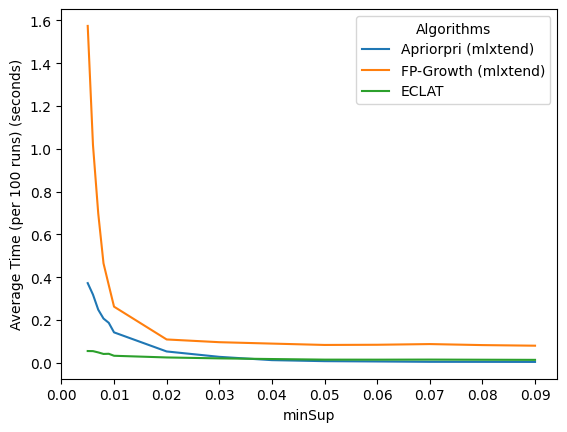

In [12]:
ax = plt.gca()
df = pd.read_csv(osp.join('..', 'Output', 'timing.csv')).set_index('minSup')
df.columns = ['Apriorpri (mlxtend)', 'FP-Growth (mlxtend)', 'ECLAT']
df.plot(ax=ax)
ax.set_xticks([i / 100 for i in range(10)])
ax.set_ylabel('Average Time (per 100 runs) (seconds)')
ax.legend(title='Algorithms')